***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.3)** 64D>32D>16D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\HD-CapsNet_MOD\Training_and_Analysis\6_Stanford_Cars
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0,1" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0,1
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Done: GPU PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
2 Physical GPUs, 2 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 16,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('6_Stanford_Cars/HD_CapsNet/Mod_3_3')

# Import Dataset : Stanford_Cars

In [6]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.Stanford_Cars(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = 'mixup',
                                                                                  data_normalizing = None)

In [7]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

## Learning Rate Decay Scheduler

In [8]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [9]:
## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": info['Num_Coarse'],
                                "medium": info['Num_Medium'],
                                "fine": info['Num_Fine']})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0
             }

In [10]:
Matrix_coarse_to_medium_OneHot = tf.constant(info['Matrix_coarse_to_medium'], dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(info['Matrix_medium_to_fine'], dtype=tf.float32)

In [11]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_pred
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,
               number_of_classes_m, number_of_classes_f, C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Architecture

In [12]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_Mod_3_3(input_shape     = image_shape, 
                                      input_shape_yc  = coarse_label_shape,
                                      input_shape_ym  = medium_label_shape,
                                      input_shape_yf  = fine_label_shape, 
                                      no_coarse_class = info['Num_Coarse'], 
                                      no_medium_class = info['Num_Medium'], 
                                      no_fine_class   = info['Num_Fine'],
                                      PCap_n_dims     = 8, 
                                      SCap_f_dims     = 16, 
                                      SCap_m_dims     = 32, 
                                      SCap_c_dims     = 64)
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c            = model.inputs[1], 
                              y_true_m            = model.inputs[2], 
                              y_true_f            = model.inputs[3], 
                              y_pred_c            = model.output[0], 
                              y_pred_m            = model.output[1], 
                              y_pred_f            = model.output[2], 
                              LW_C                = lossweight['coarse_lw'], 
                              LW_M                = lossweight['medium_lw'], 
                              LW_F                = lossweight['fine_lw'],
                              number_of_classes_m = info['Num_Medium'], 
                              number_of_classes_f = info['Num_Fine'], 
                              C_Weight            =0.2)
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [13]:
strategy = models.multi_gpu_select('windows')

print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = get_compiled_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

In [14]:
model.summary()
# keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 113)         0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 196)          0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.argmax_4 (TFOpLambda)  (None,)              0           ['input_yc[0][0]']               
                                                                                                  
 tf.cast (TFOpLambda)           (None,)              0           ['tf.math.argmax_4[0][0]']       
                                                                                                  
 tf.math.a

                                                                                                  
 tf.math.subtract_12 (TFOpLambd  (None, 196)         0           ['input_yf[0][0]']               
 a)                                                                                               
                                                                                                  
 tf.math.maximum_5 (TFOpLambda)  (None, 196)         0           ['tf.math.subtract_11[0][0]']    
                                                                                                  
 tf.math.multiply_3 (TFOpLambda  (None, 196)         0           ['tf.compat.v1.gather_3[0][0]',  
 )                                                                'prediction_fine[0][0]']        
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  (None, 196)         0           ['tf.compat.v1.gather_1[0][0]',  
 )        

                                                                                                  
 tf.math.abs_3 (TFOpLambda)     (None,)              0           ['tf.math.subtract_3[0][0]']     
                                                                                                  
 tf.math.abs_1 (TFOpLambda)     (None,)              0           ['tf.math.subtract_1[0][0]']     
                                                                                                  
 tf.math.add (TFOpLambda)       (None, 13)           0           ['tf.math.multiply_6[0][0]',     
                                                                  'tf.math.multiply_8[0][0]']     
                                                                                                  
 tf.math.multiply_13 (TFOpLambd  (None,)             0           ['tf.math.reduce_sum_5[0][0]']   
 a)                                                                                               
          

## Data Augmentation

## Training Pipeline Alignment

In [15]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_0, label_1, label_2), (label_0, label_1, label_2)

training_dataset_match = training_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = val_dataset.map(pipeline_multi_input_output) ## Val Dataset

## Callback

In [16]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [17]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_dataset_match,
                        epochs = train_params["n_epochs"],
                        validation_data = val_dataset_match,
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

Epoch 1/100
INFO:tensorflow:batch_all_reduce: 35 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 35 all-reduces with algorithm = hierarchical_copy, num_packs = 1
509/509 [==============================] - ETA: 0s - loss: 0.6069 - prediction_coarse_accuracy: 0.2331 - prediction_medium_accuracy: 0.0182 - prediction_fine_accuracy: 0.0091
  • Coarse Accuracy = 23.31% | Val_Accuracy = 18.68% | LossWeight = 0.42 
  • Medium Accuracy = 1.82% | Val_Accuracy = 1.37% | LossWeight = 0.36 
  • Fine   Accuracy = 0.91% | Val_Accuracy = 0.90% | LossWeight = 0.22 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.00896, saving model to ../../logs/6_Stanford_Cars/HD_CapsNet/Mod_3_3\epoch-best.h5
509/509 [==============================] - 258s 398ms/step - loss: 0.6069 - prediction_coarse_accuracy: 0.2331 - prediction_medium_accuracy: 0.0182 - prediction_fine_accuracy: 0.0091 - val_loss: 1.1568 - val_prediction_coarse_accuracy: 0.1868 - val_pr

509/509 [==============================] - 214s 392ms/step - loss: 0.4123 - prediction_coarse_accuracy: 0.4834 - prediction_medium_accuracy: 0.1478 - prediction_fine_accuracy: 0.1295 - val_loss: 0.4538 - val_prediction_coarse_accuracy: 0.4035 - val_prediction_medium_accuracy: 0.0918 - val_prediction_fine_accuracy: 0.0488 - lr: 0.0010
Epoch 10/100
509/509 [==============================] - ETA: 0s - loss: 0.3908 - prediction_coarse_accuracy: 0.5436 - prediction_medium_accuracy: 0.2062 - prediction_fine_accuracy: 0.1766
  • Coarse Accuracy = 54.36% | Val_Accuracy = 39.80% | LossWeight = 0.34 
  • Medium Accuracy = 20.62% | Val_Accuracy = 9.60% | LossWeight = 0.40 
  • Fine   Accuracy = 17.66% | Val_Accuracy = 5.80% | LossWeight = 0.25 

Epoch 10: val_prediction_fine_accuracy improved from 0.04876 to 0.05796, saving model to ../../logs/6_Stanford_Cars/HD_CapsNet/Mod_3_3\epoch-best.h5
509/509 [==============================] - 214s 392ms/step - loss: 0.3908 - prediction_coarse_accuracy: 0.

509/509 [==============================] - 334s 620ms/step - loss: 0.1822 - prediction_coarse_accuracy: 0.8937 - prediction_medium_accuracy: 0.7997 - prediction_fine_accuracy: 0.7251 - val_loss: 0.3846 - val_prediction_coarse_accuracy: 0.4816 - val_prediction_medium_accuracy: 0.1838 - val_prediction_fine_accuracy: 0.1381 - lr: 6.6342e-04
Epoch 19/100
509/509 [==============================] - ETA: 0s - loss: 0.1659 - prediction_coarse_accuracy: 0.9095 - prediction_medium_accuracy: 0.8427 - prediction_fine_accuracy: 0.7820
  • Coarse Accuracy = 90.95% | Val_Accuracy = 46.92% | LossWeight = 0.32 
  • Medium Accuracy = 84.27% | Val_Accuracy = 18.91% | LossWeight = 0.37 
  • Fine   Accuracy = 78.20% | Val_Accuracy = 14.10% | LossWeight = 0.31 

Epoch 19: val_prediction_fine_accuracy improved from 0.13806 to 0.14104, saving model to ../../logs/6_Stanford_Cars/HD_CapsNet/Mod_3_3\epoch-best.h5
509/509 [==============================] - 333s 623ms/step - loss: 0.1659 - prediction_coarse_accura

Epoch 28/100
509/509 [==============================] - ETA: 0s - loss: 0.1066 - prediction_coarse_accuracy: 0.9570 - prediction_medium_accuracy: 0.9449 - prediction_fine_accuracy: 0.9341
  • Coarse Accuracy = 95.70% | Val_Accuracy = 47.86% | LossWeight = 0.40 
  • Medium Accuracy = 94.49% | Val_Accuracy = 17.71% | LossWeight = 0.35 
  • Fine   Accuracy = 93.41% | Val_Accuracy = 13.91% | LossWeight = 0.25 

Epoch 28: val_prediction_fine_accuracy did not improve from 0.14925
509/509 [==============================] - 319s 594ms/step - loss: 0.1066 - prediction_coarse_accuracy: 0.9570 - prediction_medium_accuracy: 0.9449 - prediction_fine_accuracy: 0.9341 - val_loss: 0.4569 - val_prediction_coarse_accuracy: 0.4786 - val_prediction_medium_accuracy: 0.1771 - val_prediction_fine_accuracy: 0.1391 - lr: 3.9721e-04
Epoch 29/100
509/509 [==============================] - ETA: 0s - loss: 0.1037 - prediction_coarse_accuracy: 0.9598 - prediction_medium_accuracy: 0.9427 - prediction_fine_accuracy: 

509/509 [==============================] - 329s 609ms/step - loss: 0.0942 - prediction_coarse_accuracy: 0.9618 - prediction_medium_accuracy: 0.9525 - prediction_fine_accuracy: 0.9461 - val_loss: 0.4670 - val_prediction_coarse_accuracy: 0.4813 - val_prediction_medium_accuracy: 0.1786 - val_prediction_fine_accuracy: 0.1418 - lr: 2.5034e-04
Epoch 38/100
509/509 [==============================] - ETA: 0s - loss: 0.0922 - prediction_coarse_accuracy: 0.9630 - prediction_medium_accuracy: 0.9552 - prediction_fine_accuracy: 0.9494
  • Coarse Accuracy = 96.30% | Val_Accuracy = 49.03% | LossWeight = 0.42 
  • Medium Accuracy = 95.52% | Val_Accuracy = 17.84% | LossWeight = 0.34 
  • Fine   Accuracy = 94.94% | Val_Accuracy = 13.78% | LossWeight = 0.23 

Epoch 38: val_prediction_fine_accuracy did not improve from 0.14925
509/509 [==============================] - 321s 596ms/step - loss: 0.0922 - prediction_coarse_accuracy: 0.9630 - prediction_medium_accuracy: 0.9552 - prediction_fine_accuracy: 0.949

509/509 [==============================] - ETA: 0s - loss: 0.0867 - prediction_coarse_accuracy: 0.9687 - prediction_medium_accuracy: 0.9579 - prediction_fine_accuracy: 0.9509
  • Coarse Accuracy = 96.87% | Val_Accuracy = 49.43% | LossWeight = 0.39 
  • Medium Accuracy = 95.79% | Val_Accuracy = 18.08% | LossWeight = 0.36 
  • Fine   Accuracy = 95.09% | Val_Accuracy = 13.71% | LossWeight = 0.25 

Epoch 47: val_prediction_fine_accuracy did not improve from 0.14925
509/509 [==============================] - 335s 624ms/step - loss: 0.0867 - prediction_coarse_accuracy: 0.9687 - prediction_medium_accuracy: 0.9579 - prediction_fine_accuracy: 0.9509 - val_loss: 0.4584 - val_prediction_coarse_accuracy: 0.4943 - val_prediction_medium_accuracy: 0.1808 - val_prediction_fine_accuracy: 0.1371 - lr: 1.4989e-04
Epoch 48/100
509/509 [==============================] - ETA: 0s - loss: 0.0840 - prediction_coarse_accuracy: 0.9700 - prediction_medium_accuracy: 0.9621 - prediction_fine_accuracy: 0.9568
  • Co

509/509 [==============================] - 327s 611ms/step - loss: 0.0845 - prediction_coarse_accuracy: 0.9686 - prediction_medium_accuracy: 0.9589 - prediction_fine_accuracy: 0.9542 - val_loss: 0.4591 - val_prediction_coarse_accuracy: 0.4896 - val_prediction_medium_accuracy: 0.1799 - val_prediction_fine_accuracy: 0.1266 - lr: 9.4468e-05
Epoch 57/100
509/509 [==============================] - ETA: 0s - loss: 0.0870 - prediction_coarse_accuracy: 0.9651 - prediction_medium_accuracy: 0.9600 - prediction_fine_accuracy: 0.9547
  • Coarse Accuracy = 96.51% | Val_Accuracy = 49.33% | LossWeight = 0.43 
  • Medium Accuracy = 96.00% | Val_Accuracy = 18.11% | LossWeight = 0.34 
  • Fine   Accuracy = 95.47% | Val_Accuracy = 13.33% | LossWeight = 0.23 

Epoch 57: val_prediction_fine_accuracy did not improve from 0.14925
509/509 [==============================] - 335s 625ms/step - loss: 0.0870 - prediction_coarse_accuracy: 0.9651 - prediction_medium_accuracy: 0.9600 - prediction_fine_accuracy: 0.954

509/509 [==============================] - ETA: 0s - loss: 0.0850 - prediction_coarse_accuracy: 0.9684 - prediction_medium_accuracy: 0.9595 - prediction_fine_accuracy: 0.9542
  • Coarse Accuracy = 96.84% | Val_Accuracy = 49.78% | LossWeight = 0.41 
  • Medium Accuracy = 95.95% | Val_Accuracy = 18.43% | LossWeight = 0.35 
  • Fine   Accuracy = 95.42% | Val_Accuracy = 12.86% | LossWeight = 0.24 

Epoch 66: val_prediction_fine_accuracy did not improve from 0.14925
509/509 [==============================] - 318s 592ms/step - loss: 0.0850 - prediction_coarse_accuracy: 0.9684 - prediction_medium_accuracy: 0.9595 - prediction_fine_accuracy: 0.9542 - val_loss: 0.4656 - val_prediction_coarse_accuracy: 0.4978 - val_prediction_medium_accuracy: 0.1843 - val_prediction_fine_accuracy: 0.1286 - lr: 5.6562e-05
Epoch 67/100
509/509 [==============================] - ETA: 0s - loss: 0.0856 - prediction_coarse_accuracy: 0.9702 - prediction_medium_accuracy: 0.9574 - prediction_fine_accuracy: 0.9549
  • Co

509/509 [==============================] - 293s 539ms/step - loss: 0.0834 - prediction_coarse_accuracy: 0.9697 - prediction_medium_accuracy: 0.9643 - prediction_fine_accuracy: 0.9591 - val_loss: 0.4625 - val_prediction_coarse_accuracy: 0.4988 - val_prediction_medium_accuracy: 0.1766 - val_prediction_fine_accuracy: 0.1316 - lr: 3.5648e-05
Epoch 76/100
509/509 [==============================] - ETA: 0s - loss: 0.0860 - prediction_coarse_accuracy: 0.9707 - prediction_medium_accuracy: 0.9628 - prediction_fine_accuracy: 0.9575
  • Coarse Accuracy = 97.07% | Val_Accuracy = 49.88% | LossWeight = 0.41 
  • Medium Accuracy = 96.28% | Val_Accuracy = 17.81% | LossWeight = 0.35 
  • Fine   Accuracy = 95.75% | Val_Accuracy = 13.23% | LossWeight = 0.24 

Epoch 76: val_prediction_fine_accuracy did not improve from 0.14925
509/509 [==============================] - 285s 526ms/step - loss: 0.0860 - prediction_coarse_accuracy: 0.9707 - prediction_medium_accuracy: 0.9628 - prediction_fine_accuracy: 0.957

509/509 [==============================] - ETA: 0s - loss: 0.0865 - prediction_coarse_accuracy: 0.9668 - prediction_medium_accuracy: 0.9586 - prediction_fine_accuracy: 0.9541
  • Coarse Accuracy = 96.68% | Val_Accuracy = 49.80% | LossWeight = 0.42 
  • Medium Accuracy = 95.86% | Val_Accuracy = 17.81% | LossWeight = 0.35 
  • Fine   Accuracy = 95.41% | Val_Accuracy = 13.01% | LossWeight = 0.23 

Epoch 85: val_prediction_fine_accuracy did not improve from 0.14925
509/509 [==============================] - 235s 433ms/step - loss: 0.0865 - prediction_coarse_accuracy: 0.9668 - prediction_medium_accuracy: 0.9586 - prediction_fine_accuracy: 0.9541 - val_loss: 0.4569 - val_prediction_coarse_accuracy: 0.4980 - val_prediction_medium_accuracy: 0.1781 - val_prediction_fine_accuracy: 0.1301 - lr: 2.1344e-05
Epoch 86/100
509/509 [==============================] - ETA: 0s - loss: 0.0842 - prediction_coarse_accuracy: 0.9700 - prediction_medium_accuracy: 0.9625 - prediction_fine_accuracy: 0.9584
  • Co

509/509 [==============================] - 234s 431ms/step - loss: 0.0814 - prediction_coarse_accuracy: 0.9732 - prediction_medium_accuracy: 0.9632 - prediction_fine_accuracy: 0.9606 - val_loss: 0.4552 - val_prediction_coarse_accuracy: 0.4983 - val_prediction_medium_accuracy: 0.1786 - val_prediction_fine_accuracy: 0.1286 - lr: 1.3452e-05
Epoch 95/100
509/509 [==============================] - ETA: 0s - loss: 0.0842 - prediction_coarse_accuracy: 0.9719 - prediction_medium_accuracy: 0.9621 - prediction_fine_accuracy: 0.9565
  • Coarse Accuracy = 97.19% | Val_Accuracy = 49.88% | LossWeight = 0.39 
  • Medium Accuracy = 96.21% | Val_Accuracy = 17.89% | LossWeight = 0.36 
  • Fine   Accuracy = 95.65% | Val_Accuracy = 12.86% | LossWeight = 0.25 

Epoch 95: val_prediction_fine_accuracy did not improve from 0.14925
509/509 [==============================] - 239s 442ms/step - loss: 0.0842 - prediction_coarse_accuracy: 0.9719 - prediction_medium_accuracy: 0.9621 - prediction_fine_accuracy: 0.956

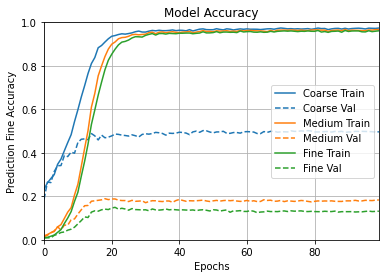

In [18]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

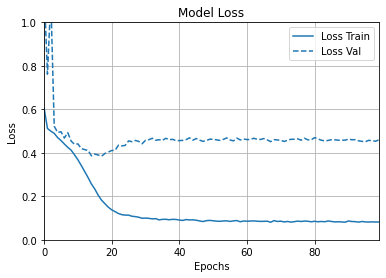

In [19]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [20]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [21]:
results = final_model.evaluate(test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',final_model.metrics_names[n], '==>', results[n])
model_predictions = final_model.predict(test_dataset)

252/252 [==============================] - 39s 138ms/step - loss: 0.5413 - prediction_coarse_loss: 0.3741 - prediction_medium_loss: 0.6371 - prediction_fine_loss: 0.6804 - prediction_coarse_accuracy: 0.4976 - prediction_medium_accuracy: 0.1825 - prediction_fine_accuracy: 0.1316
1. loss ==> 0.5413225889205933
2. prediction_coarse_loss ==> 0.3741472661495209
3. prediction_medium_loss ==> 0.6371138691902161
4. prediction_fine_loss ==> 0.6803973913192749
5. prediction_coarse_accuracy ==> 0.49763739109039307
6. prediction_medium_accuracy ==> 0.1825416535139084
7. prediction_fine_accuracy ==> 0.1315593123435974


In [22]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    image = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
                image.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
                image[i] = list(x[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
                image[i] = image[i] + list(x[i].numpy())
    return y_true, y_pred, image

In [23]:
predictions = []
predictions.append(predict_from_pipeline(final_model, test_dataset))

In [24]:
dataset= {'x_test':predictions[0][2][0], 
          'y_test_coarse':predictions[0][0][0], 
          'y_test_medium':predictions[0][0][1], 
          'y_test_fine':predictions[0][0][2]}

In [25]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0][1][0],predictions[0][1][1],predictions[0][1][2]]

  • Confusion_Matrix 

  • COARSE LEVEL 
[[225  96   0   1   1  21   3   4   2 121  17   2   2]
 [ 66 277   0   2   2  36   4   8   1 185  17   2   3]
 [  6   1   0   0   0   0   0   0   0   5   1   0   0]
 [  3   5   0  53  12   3   0   4   6  10  72   1   3]
 [  1   2   0  15  27   4   0   1   9   6  22   4   3]
 [ 36  66   0   4   1  48   2   4   2 109  30   1   3]
 [  9  23   0   0   0   2   2   1   0  11   2   0   0]
 [  9   5   0   1   0   4   0  39   0  53  32   4   3]
 [  7   1   0  18   7   1   0   1  17   6  20   2   1]
 [ 74 142   0   9   3  42   2  15   3 688  59   6  15]
 [ 15  26   0  18   5  28   0  10   6  81 517   4   4]
 [  8   3   0   2   2   4   0   1   2   8  14  96   1]
 [ 11  21   0   3   0  10   0   2   1  44  40   0  12]]

  • MEDIUM LEVEL 
[[ 5  1  0 ...  0  0  0]
 [ 1 21  0 ...  0  0  0]
 [ 0  1 15 ...  0  0  0]
 ...
 [ 0  1  1 ...  1  1  0]
 [ 1  2  0 ...  1  2  0]
 [ 0  0  0 ...  0  0  2]]

  • FINE LEVEL 
[[7 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 2 4 ... 0

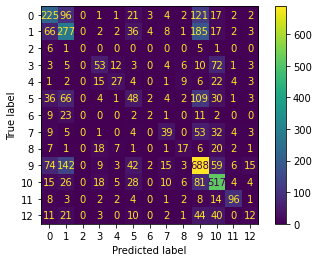

D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\knoor\AnacondaEnvironment\py38tf28\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0    0.47872   0.45455   0.46632       495
           1    0.41467   0.45937   0.43588       603
           2    0.00000   0.00000   0.00000        13
           3    0.42063   0.30814   0.35570       172
           4    0.45000   0.28723   0.35065        94
           5    0.23645   0.15686   0.18861       306
           6    0.15385   0.04000   0.06349        50
           7    0.43333   0.26000   0.32500       150
           8    0.34694   0.20988   0.26154        81
           9    0.51846   0.65028   0.57694      1058
          10    0.61329   0.72409   0.66410       714
          11    0.78689   0.68085   0.73004       141
          12    0.24000   0.08333   0.12371       144

    accuracy                        0.49764      4021
   macro avg    0.39179   0.33189   0.34938      4021
weighted avg    0.47420   0.49764   0.47847      4021


  • MEDIUM LEVEL 


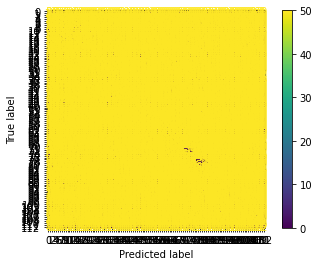

              precision    recall  f1-score   support

           0    0.13514   0.13514   0.13514        37
           1    0.15789   0.24419   0.19178        86
           2    0.38462   0.39474   0.38961        38
           3    0.31818   0.36842   0.34146        19
           4    0.07500   0.07143   0.07317        42
           5    0.07692   0.07317   0.07500        41
           6    0.22642   0.26087   0.24242        46
           7    0.16807   0.20408   0.18433        98
           8    0.09524   0.08696   0.09091        23
           9    0.14474   0.20755   0.17054       106
          10    0.20000   0.10526   0.13793        19
          11    0.11765   0.15385   0.13333        13
          12    0.14634   0.15000   0.14815        40
          13    0.15385   0.16667   0.16000        60
          14    0.14754   0.11392   0.12857        79
          15    0.23913   0.23404   0.23656        47
          16    0.06897   0.07407   0.07143        54
          17    0.36667   0

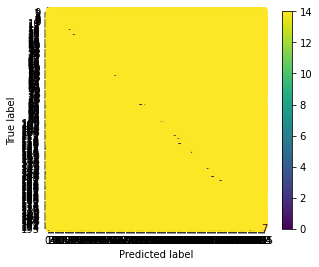

              precision    recall  f1-score   support

           0    0.28000   0.36842   0.31818        19
           1    0.00000   0.00000   0.00000        20
           2    0.16000   0.19048   0.17391        21
           3    0.05263   0.04167   0.04651        24
           4    0.00000   0.00000   0.00000        21
           5    0.09524   0.11111   0.10256        18
           6    0.08333   0.10526   0.09302        19
           7    0.10345   0.13636   0.11765        22
           8    0.04762   0.05556   0.05128        18
           9    0.07143   0.05000   0.05882        20
          10    0.12000   0.13043   0.12500        23
          11    0.09091   0.09524   0.09302        21
          12    0.00000   0.00000   0.00000        22
          13    0.00000   0.00000   0.00000        19
          14    0.33333   0.14286   0.20000        21
          15    0.05000   0.04545   0.04762        22
          16    0.27778   0.25000   0.26316        20
          17    0.14286   0

In [26]:
metrics.lvl_wise_metric(true_label,pred_label)

In [27]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,pred_label,tree)
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.25127663102047587 
Hierarchical Recall = 0.32835944624057034 
Hierarchical F1-Score = 0.2802982753243883 
Consistency =  0.2777915941308132 
Exact Match =  0.07460830639144492
